In [1]:
from utils import * 
from algorithms import *
from agents import *
import warnings 
warnings.filterwarnings('ignore')
import torch as th
th.autograd.set_detect_anomaly(True)

In [2]:
def generateState(agent):
    counters = [agent.periodSteps, agent.stepTrades] #, agent.periodProfits, agent.stepTokenValue]
    disclosureLength = len(agent.disclosure)
    if (disclosureLength == 0) | (agent.depth == 0):
        activityLog = []
    else:   
        if agent.gameSteps >= agent.depth:
            agent.disclosureCopy = deepcopy(agent.disclosure)
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                agent.disclosureCopy.remove('bids')
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                agent.disclosureCopy.remove('asks')
                asksDisclose = True
            
            activityLog = [[]]
            for i in range(1, agent.depth+1):
                activityLog[0] += agent.df.iloc[-i][agent.disclosureCopy].tolist()           
                if bidsDisclose:
                    activityLog[0] += agent.df.iloc[-i].bids
                if asksDisclose:
                    activityLog[0] += agent.df.iloc[-i].asks
            activityLog = activityLog[0]
        else:
            bidsDisclose, asksDisclose = False, False
            if 'bids' in agent.disclosure:
                disclosureLength -= 1
                bidsDisclose = True
            if 'asks' in agent.disclosure:
                disclosureLength -= 1
                asksDisclose = True
            activityLog = [-1] * (disclosureLength*agent.depth + bidsDisclose*agent.depth*agent.numBuyers+asksDisclose*agent.depth*agent.numSellers)
        
    state = counters + activityLog
    cleanState = [-1 if np.isnan(x) else x for x in state]
    return cleanState



class Reinforcer(Trader):
    def __init__(self, gameData, disclosure=['currentBid', 'currentAsk', 'buy', 'sell', 'price', 'price'], 
                 index=0, buyer=1, reinforcer=1, numActions=10, algo='VPG', algoArgs=[], depth = 0, verbose = 0):
        super().__init__(gameData, disclosure, index, buyer, reinforcer)
        self.depth = depth
        self.disclosure = disclosure
        self.state = generateState(self)
        self.numStates = len(self.state)
        self.numActions = numActions
        self.state = [-1]*self.numStates
        self.algo = loadAlgo(algo, self.numStates, self.numActions, *algoArgs)
        self.done = False
        self.verbose = verbose
    
    def observe(self):
        self.newState = generateState(self)
        self.algo.observe(self.state, self.action, self.stepProfits, self.newState, self.done)
        if self.verbose == 1:
            print(self.state, self.action, self.stepProfits, self.newState, self.done)
        self.state = self.newState
        if (self.periodSteps == self.numSteps-1): # & (self.roundPeriods == self.numPeriods-1):
            self.done = True
        else:
            self.done = False

    def train(self):
        self.algo.train(self.state, self.action, self.stepProfits, self.newState, self.done)
        
    def bid(self):
        self.stepBid = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            self.stepBid = (self.action/(self.numActions-1)) * 100
        return self.stepBid
        
    def ask(self):
        self.stepAsk = np.nan
        self.action = self.algo.act(self.state)
        if self.stepTokenValue >= 0:
            self.stepAsk = (self.action/(self.numActions-1)) * 100
        return self.stepAsk

In [3]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import collections, random

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)

class PolicyNet(nn.Module):
    def __init__(self, learning_rate):
        super(PolicyNet, self).__init__()
        global num_states
        self.fc1 = nn.Linear(num_states, 128)
        self.fc_mu = nn.Linear(128,1)
        self.fc_std  = nn.Linear(128,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.log_alpha = torch.tensor(np.log(init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=lr_alpha)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7)
        return real_action, real_log_prob

    def train_net(self, q1, q2, mini_batch):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

class QNet(nn.Module):
    def __init__(self, learning_rate):
        global num_states
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(num_states, 64)
        self.fc_a = nn.Linear(1, 64)
        self.fc_cat = nn.Linear(128,32)
        self.fc_out = nn.Linear(32,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_cat(cat))
        q = self.fc_out(q)
        return q

    def train_net(self, target, mini_batch):
        s, a, r, s_prime, done = mini_batch
        loss = F.smooth_l1_loss(self.forward(s, a) , target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def soft_update(self, net_target):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

def calc_target(pi, q1, q2, mini_batch):
    s, a, r, s_prime, done = mini_batch

    with torch.no_grad():
        a_prime, log_prob= pi(s_prime)
        entropy = -pi.log_alpha.exp() * log_prob
        q1_val, q2_val = q1(s_prime,a_prime), q2(s_prime,a_prime)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]
        target = r + gamma * done * (min_q + entropy)

    return target

In [5]:
from copy import deepcopy
import gymnasium as gym
from gymnasium import spaces

class GymEnv(gym.Env):
    def __init__(self, metaData, buyers, sellers, log):
        self.gameData = metaData[0:8]
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = self.gameData
        self.disclosure, self.buyers, self.sellers = metaData[8:]
        self.log = log
        self.rnd = 0
        self.period = 0
        self.Step = 0
        self.action_space = spaces.Box(-1,1,(1,),dtype=np.float32)
        self.numStates = len(generateState(self.buyers[0]))
        self.observation_space = spaces.Box(-1,9,(self.numStates,),dtype=np.float32)
        startRounds(self.gameData, self.log, self.buyers, self.sellers, self.rnd)
    
    def reset(self, seed = None):
        startPeriods(self.buyers, self.sellers)
        generateState(self.buyers[0])
        return self.buyers[0].state, {}

    def step(self, action):
        startSteps(self.buyers, self.sellers)
        bids, asks = collectOffers(self.buyers, self.sellers)
        min = buyers[0].stepTokenValue*0.1
        max = buyers[0].stepTokenValue
        bids[0] = min * (1-(action[0]+1)/2) + (action[0]+1)/2 * max
        currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
        price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
        bprofit, sprofit = 0, 0
        if price > 0:
            self.buyers[currentBidIdx].transact(price)
            self.sellers[currentAskIdx].transact(price)
            bprofit = self.buyers[currentBidIdx].stepProfits
            sprofit = self.sellers[currentAskIdx].stepProfits
        self.log.addStep([self.rnd, self.period, self.Step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
        observe(self.buyers, self.sellers, log.disclose())
        reward = 0.0
        if price > 0 and currentBidIdx == 0:
            reward = np.nan_to_num(bprofit,nan=0)
        updateStates(self.buyers, self.sellers)
        newState = self.buyers[0].state
        done = self.buyers[0].done
        updatePolicy(self.buyers, self.sellers)
        endSteps(self.buyers, self.sellers)
        self.Step += 1
        if done:
            endPeriods(self.buyers, self.sellers)
            self.period += 1
            self.Step = 0
        return newState, reward, done, False, {}

numRounds, numPeriods, numSteps = 1, 10000, 9
numBuyers, numSellers, numTokens = 3, 6, 4
gameTypes, seed = '5115', 42
disclosure = []
disclosure = ['currentAsk', 'currentBid', 'currentAskIdx', 'currentBidIdx', 'price', 'sale', 'bids', 'asks']
depth = 0
# ZeroIntelligence, TruthTeller

gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]

buyers = [
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, depth = depth, algo='BASE'),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
]
sellers = [
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
    ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
         ]
log = Log(gameData, disclosure)
metaData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed, disclosure, buyers, sellers]
env = GymEnv(metaData, buyers, sellers, log)
env.reset()
print(log.roundData.iloc[0].buyerValues)
print(log.roundData.iloc[0].sellerCosts)
print(buyers[0].state)

[[ 99.25003886  82.45671643  77.66026229  65.21989865]
 [100.          84.05672672  63.22103594  62.96150214]
 [ 78.67729377  60.07550004  59.31575489  58.17739974]]
[[11.47061757 16.75562681 39.29472894 54.31626246]
 [22.83601084 29.76199996 33.6351073  56.56277446]
 [22.02002285 45.1952035  52.5790546  78.76449945]
 [27.9216024  38.27685302 51.64216474 57.74193037]
 [36.9662783  38.72188629 43.40438254 87.08807828]
 [24.4482233  26.90662066 47.53168931 66.02949848]]
[-1, -1]


In [7]:
lr_pi           = 1e-5
lr_q            = 1e-5
init_alpha      = 0.5
gamma           = 0.99
batch_size      = 128
buffer_limit    = 1000000
tau             = 0.005 # for target network soft update
target_entropy  = -1.0 # for automated alpha update
lr_alpha        = 1e-5  # for automated alpha update
grad_steps      = 1
learning_start  = 5000
num_states      = 2

memory = ReplayBuffer()
q1, q2, q1_target, q2_target = QNet(lr_q), QNet(lr_q), QNet(lr_q), QNet(lr_q)
pi = PolicyNet(lr_pi)

q1_target.load_state_dict(q1.state_dict())
q2_target.load_state_dict(q2.state_dict())

score = 0.0
print_interval = 50

In [ ]:
for n_epi in range(10000):
    s, _ = env.reset()
    done = False
    count = 0

    while not done:
        a, log_prob = pi(torch.from_numpy(np.array(s)).float())
        s_prime, r, done, truncated, info = env.step([a.item()])
        memory.put((s, a.item(), r, s_prime, done))
        score +=r
        s = s_prime
        count += 1
        #print(f"action :{a.item()}, r: {r}")
 
    if memory.size()>learning_start:
        for i in range(grad_steps):
            mini_batch = memory.sample(batch_size)
            td_target = calc_target(pi, q1_target, q2_target, mini_batch)
            q1.train_net(td_target, mini_batch)
            q2.train_net(td_target, mini_batch)
            entropy = pi.train_net(q1, q2, mini_batch)
            q1.soft_update(q1_target)
            q2.soft_update(q2_target)
            
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f} alpha:{:.4f}".format(n_epi, score/print_interval, pi.log_alpha.exp()))
        score = 0.0

# of episode :50, avg score : 103.9 alpha:0.5000
# of episode :100, avg score : 100.9 alpha:0.5000
# of episode :150, avg score : 108.7 alpha:0.4998
# of episode :200, avg score : 105.7 alpha:0.4995
# of episode :250, avg score : 106.1 alpha:0.4993
# of episode :300, avg score : 111.5 alpha:0.4990
# of episode :350, avg score : 112.5 alpha:0.4987
# of episode :400, avg score : 128.0 alpha:0.4985
# of episode :450, avg score : 123.5 alpha:0.4982
# of episode :500, avg score : 124.3 alpha:0.4979
# of episode :550, avg score : 119.2 alpha:0.4977
# of episode :600, avg score : 124.2 alpha:0.4974
# of episode :650, avg score : 120.6 alpha:0.4971
# of episode :700, avg score : 120.5 alpha:0.4969
# of episode :750, avg score : 124.1 alpha:0.4966
# of episode :800, avg score : 121.5 alpha:0.4963
# of episode :850, avg score : 120.3 alpha:0.4961
# of episode :900, avg score : 126.6 alpha:0.4958
# of episode :950, avg score : 121.8 alpha:0.4956
# of episode :1000, avg score : 125.2 alpha:0.4953


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f6389a6b920>
Traceback (most recent call last):
  File "/econ_share/home/pp712/myenv/lib/python3.11/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


KeyboardInterrupt: 

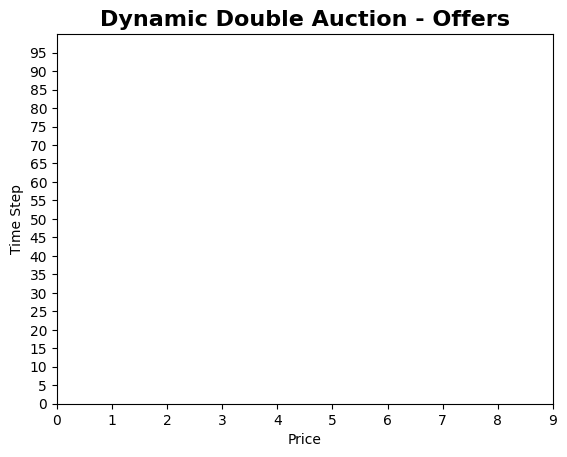

In [9]:
log.graphTraining(maxNumPeriods=1700, skip = 17)

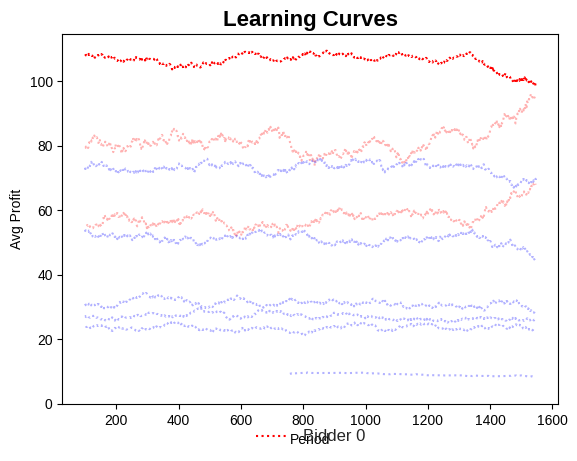

In [10]:
log.graphLearning(trackBuyersIdx = [0], trackSellersIdx = [], rolling_window=100, type = 'period')